# Time series

In previous chapters we have only seen examples where samples in the dataset are independent. Time-dependent signals where each data point is related to its neighbours present additional challenges for model selection and training. Most modelling is based on the idea that the data have some regularity, i.e. there are patterns that repeat over time. A single signal can be composed of multiple such pattern, think for example of the electricity consumption of a family which will depend:
- on the time time of the day
- on the day of the week (week-ends)
- on holidays
- etc.

In such a case a model can attempt to give different weights to each pattern in an optimal way, in order to predict future signal. There are also more general models, mostly based on deep learning, that try to model "any" time-series, i.e. even those without regular patterns. This remains however an extremly difficult task (otherwise, the stockmarket could be predicted...).

Here we first present the general concept of time-series modelling and then briefly present a few examples using [sktime](https://www.sktime.net/en/stable/index.html) a library that proposes a general framework for time-series modelling using multiple other libraries under the hood.

## Time-series: seasonality and trend

As mentioned above, time-series analysis usually considers signals that have some periodicity and trends. Here we load some data from the statsmodels package about CO2 production:

In [115]:
from statsmodels.datasets import co2

In [148]:
data = co2.load().data

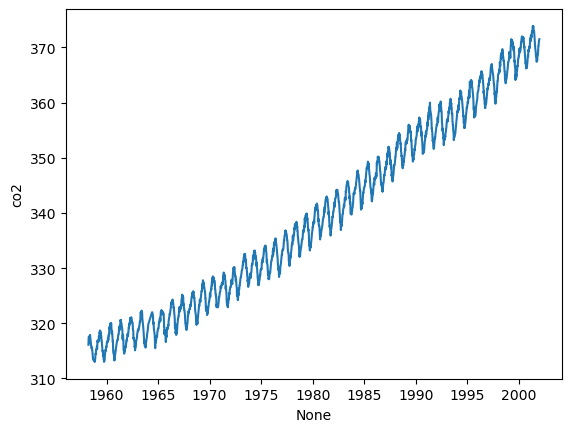

In [149]:
sns.lineplot(x=data.index, data=data, y='co2');

We clearly see here that we have a long-term trend and on top of it, we have a short term oscillation. So essentially we can decompose such signal as: $D(t) = T(t) + S(t) + e(t)$ where $T$ is the trend, $S$ the seasonality and $e$ the error. Here the signals are added to each (additive model) other but sometimes it makes sense to multiply them: $D(t) = T(t) * S(t) * e(t)$ (multiplicative model).

In principle we can now create a new sklearn model and add more complex features than we did previously. First we need to work on the date:

In [150]:
data.head(3)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6


We see that the date is in the index in date time format. We first turn it into a regular column and rename it:

In [151]:
data.reset_index(inplace=True)
data.rename(columns={'index':'date'}, inplace=True)

Our oscillation dependency is a **monthly** depencency i.e. we will have a function $f(month)$ in our model. The larger trend is **yearly**. So we need to add columns specifically for the month and year:

In [152]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

Finally we drop missing values:

In [153]:
data.dropna(inplace=True)

Now we can try to fit a model to these data. The year and month are our features that we want to use to predict the co2 level:

In [154]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=data[['year','month']], y=data['co2'])

LinearRegression()

<Axes: xlabel='date', ylabel='co2'>

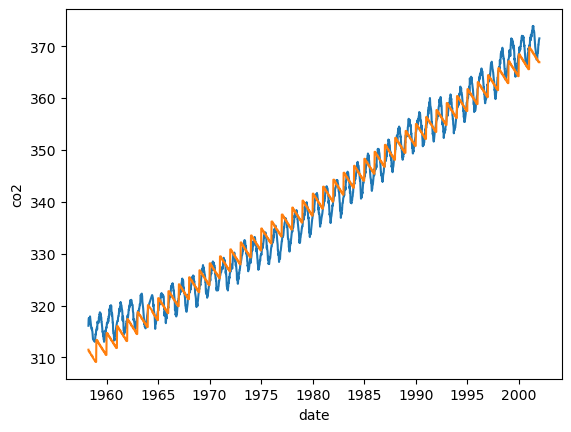

In [156]:
X_pred = data[['year','month']]
y_pred = model.predict(X_pred)

sns.lineplot(data=data, x='date', y='co2')
sns.lineplot(x=data.date, y=y_pred)

We see that we can capture the larger trend, but the monthly oscillation is just represented as a line. To get a better result, we need to add features. Previously we added only polynomials, but we can add any transformation to our data. For example sin and cos signals. For this we use the ```FunctionTransformer```:

In [157]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [158]:
data["month_sin"] = sin_transformer(12).fit_transform(data[["month"]])
data["month_cos"] = cos_transformer(12).fit_transform(data[["month"]])

In [159]:
data.head(3)

,date,co2,year,month,month_sin,month_cos
0,1958-03-29,316.1,1958,3,1.000000,6.123234e-17
1,1958-04-05,317.3,1958,4,0.866025,-5.000000e-01
2,1958-04-12,317.6,1958,4,0.866025,-5.000000e-01


We have new engineered variables that represent the monthly oscillating pattern! Let's fit the model again:

In [160]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X=data[['year', 'month','month_sin','month_cos']], y=data['co2'])

LinearRegression()

In [161]:
X_pred = data[['year','month', 'month_sin','month_cos']]
y_pred = model.predict(X_pred)

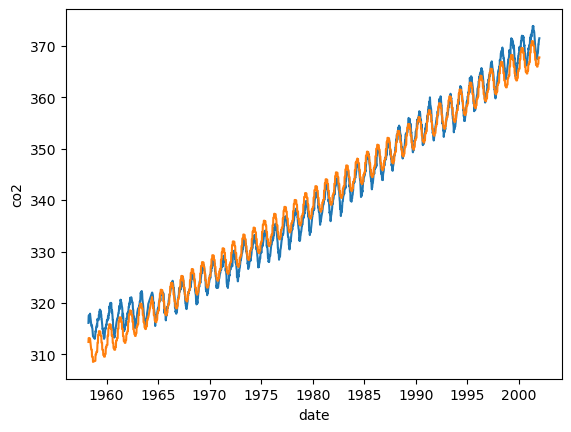

In [163]:
sns.lineplot(data=data, x='date', y='co2')
sns.lineplot(x=data.date, y=y_pred);

While still not perfect, the model catches the behaviour much better than before!

## Decomposition

This decomposition work can be automated away with various packages. For example statsmodels offers a function that more or less does what we have done above. We simply need to specify the periodicity of the signal. Here we have weekly data points, so the signal repeats every 52 weeks:

In [195]:
from statsmodels.tsa.seasonal import seasonal_decompose
data = co2.load().data
data.dropna(inplace=True)

result_add = seasonal_decompose(data['co2'], model='additive', period=52)

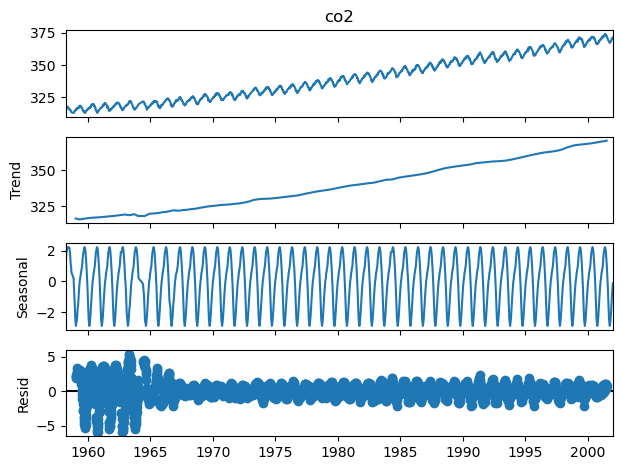

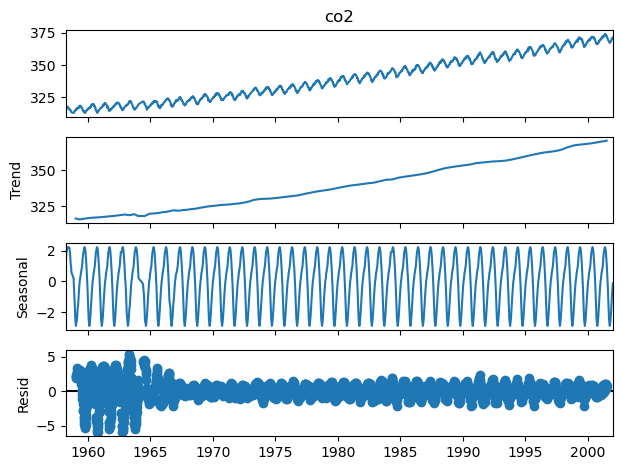

In [196]:
result_add.plot()

## sktime

There are a number of packages designed specifically to process time series in a simpler and more powerful way that we did above. ```sktime``` offers a unified interface to these packages and we are exploring some simple aspects of this libary here:

## Data import and format

First we need to import data. Here again the package comes with some example data that are useful for exploration. We use here a dataset on the number of passenger of airlines since 1949:

In [209]:
from sktime.datasets import load_airline
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [210]:
y = load_airline()
y

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

We see that we are dealing here with a Pandas series. The specificity of this series is that the index is not just a range of indices, but an actual data. If we check, we see that:

In [211]:
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Period', length=144)

the index is actually specifically a "time-object" which allows to hanle regular periods of time. Pandas has extensive functions to handle such data. For example a period range can be create with:

In [212]:
import pandas as pd

In [213]:
pd.period_range(start="2020-05-01", end="2024-08-01", freq='M')

PeriodIndex(['2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10',
             '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
             '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10',
             '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04',
             '2024-05', '2024-06', '2024-07', '2024-08'],
            dtype='period[M]')

Here we set the start and end dates plus the frequency, and a list of year-month is returned.

Let's now plot the data. We can just plot the values, e.g. with Matplotlib, but we can also use a special function from sktime, that nicely handles dates as labels:

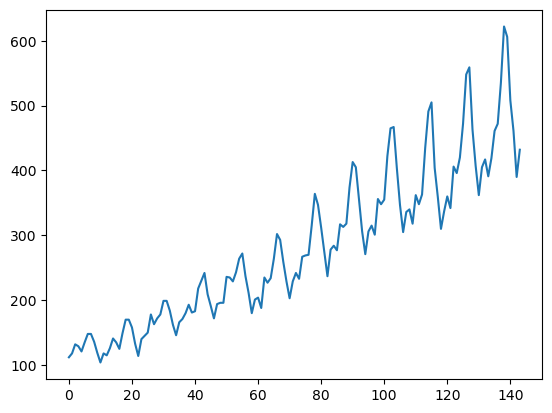

In [214]:
import matplotlib.pyplot as plt
plt.plot(y.values);

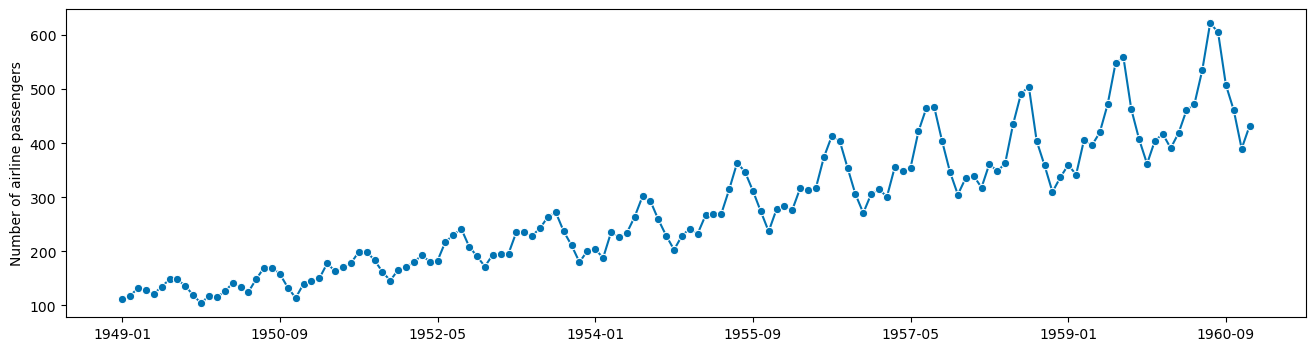

In [215]:
from sktime.utils.plotting import plot_series

plot_series(y);

## Forecasting 

We can try to make some forecasting, i.e. predict the future given past knowledge. But let's first consider what the model should understand from the data: it has a regular montly pattern that seems to repeat each year, and in addition there's a constant increase across time.

Our first approach is with a "naive" forecaster, i.e. a foreacster that only considers a recent window and extends what it sees there using a simple strategy such as computing the mean. ```sktime``` works very similarly to scikit-learn. We initialize a model. For this we specify to use the most recent window of data to do the prediction. We also specify the seasonal periodicity (```sp```) which in this case is 12 since we have montly data.

In [216]:
from sktime.forecasting.naive import NaiveForecaster

In [217]:
forecaster = NaiveForecaster(strategy="last", sp=12)

And then we fit the model with our data:

In [218]:
forecaster.fit(y)

NaiveForecaster(sp=12)

Finally we can make a prediction with the trained model:

In [219]:
fh = np.arange(1, 37)

In [220]:
y_pred = forecaster.predict(fh)

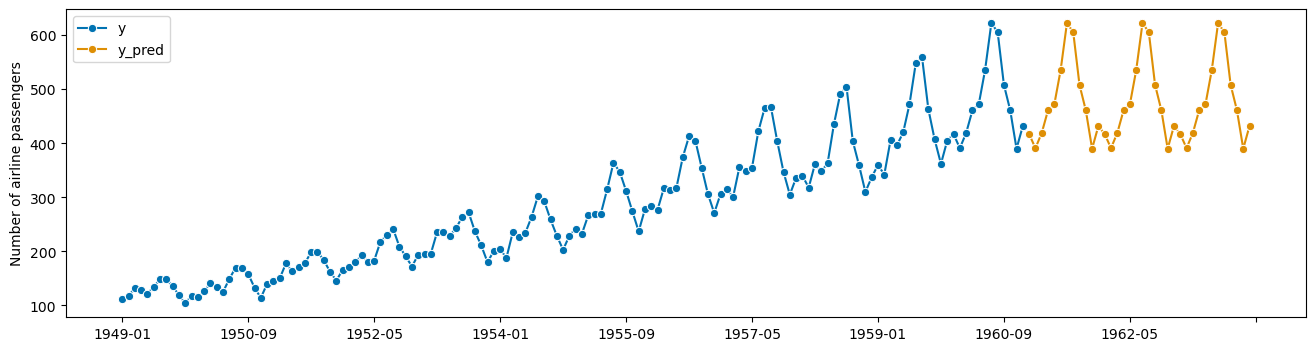

In [222]:
plot_series(y, y_pred, labels=["y", "y_pred"]);

We see that the model just reproduces the last period of our data. If we use the ```mean``` strategy, all possible periods are used for training giving:

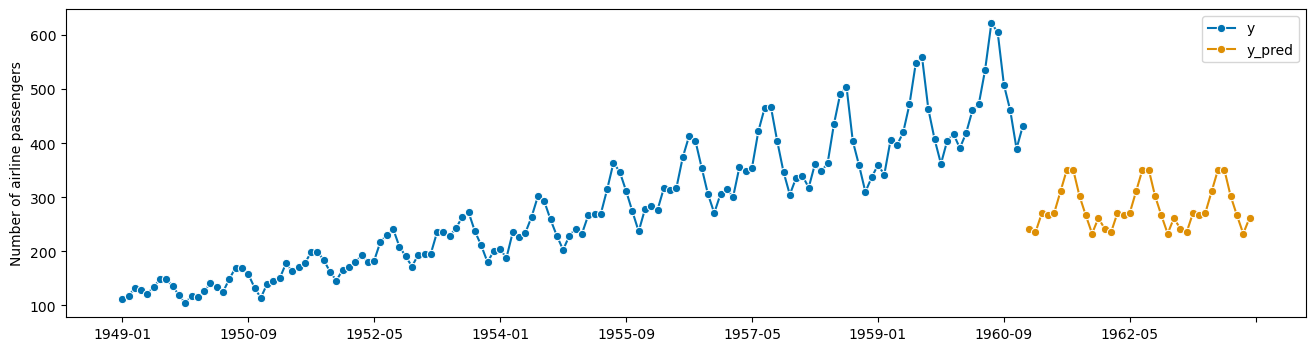

In [223]:
forecaster = NaiveForecaster(strategy="mean", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["y", "y_pred"]);

Since previous periods had smaller values, the average prediction is smaller too making this a worse choice.

There are of course much better forecasters than the naive one. ```sktime``` makes many methods from other packagages such as Prophet or statsmodels available through its interface. For example we can try and ETS model from statsmodels. These models also consider past events but consider specifically a Trend and a Seasonality:

In [224]:
from sktime.forecasting.ets import AutoETS

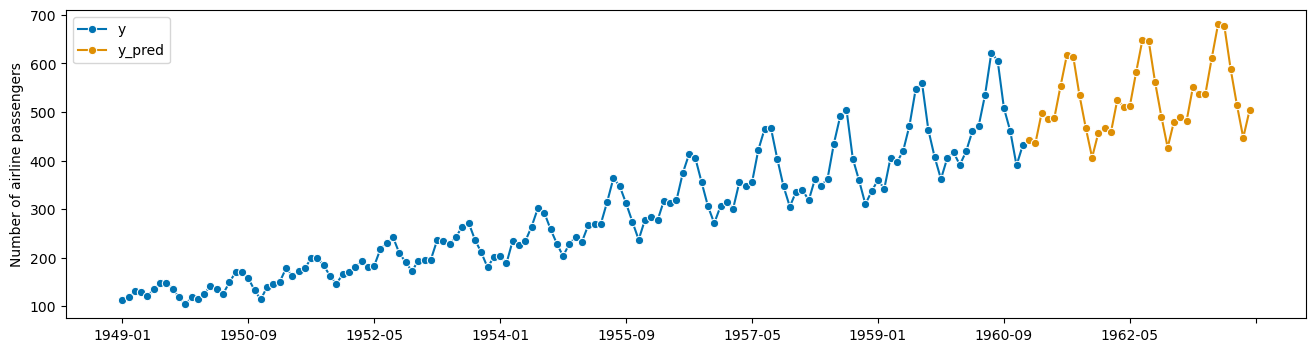

In [225]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["y", "y_pred"]);

We see that out of the box we cget a results that seems much more realistic than before. And similarly has to what we have seen in sklearn the code always remains the same!

## Checking quality

Until now we have only predicted future values and checked whether they "made sense". In reality to check a model, similarly to what we have seen previously, we can simply create a train-test split. We however need to be careful here: we cannot use a random split, as this would createa strange dataset for training. sktime offers its own function that splits data *in time*:

In [226]:
from sktime.split import temporal_train_test_split

In [227]:
y_train, y_test = temporal_train_test_split(y, test_size=36)

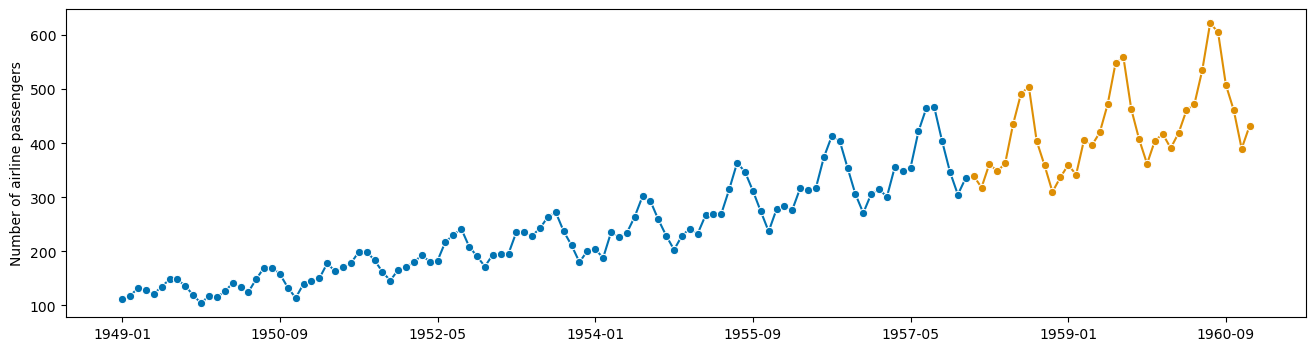

In [228]:
plot_series(y_train, y_test);

We can now fit our model with the training set and test it on the last portion:

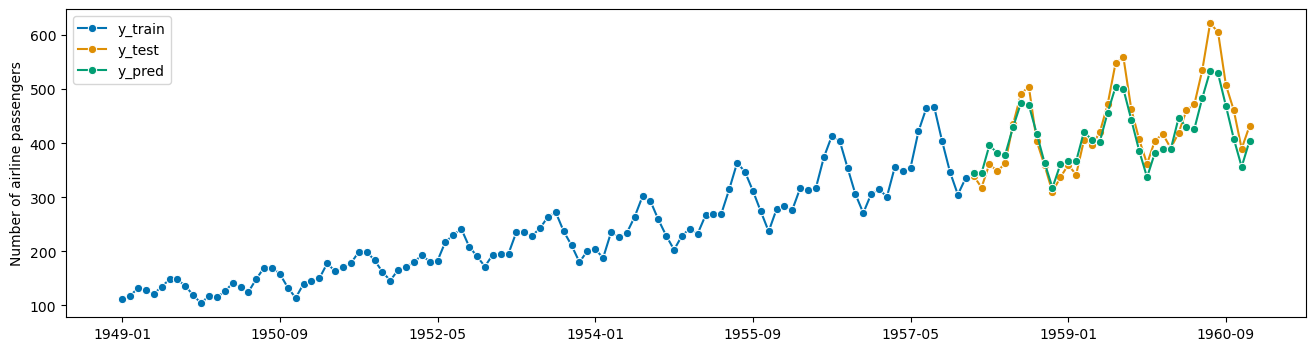

In [229]:
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(y_test.index)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

As before we want to compute some quality metric and here to sktime has its own set of metrics in a module. For example the average error:

In [230]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [231]:
mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)

0.06187403329765252

## More models

sktime gives access to a large collection of models, and it is impossible here to cover them in detail. We just give a few indications on the specificities of some of them.

### BATS and TBATS

These are some of the most complex models. In particular they allow to model data with multiple seasonalities. To summarise, BATS defines a complex function with many terms (see e.g. [here](https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a) for the equations), each corresponding to a specific effect. When searching for the optimal model, BATS will explore many combinations of models and essentially keep the best but also simplest one. We can try it one our simple data:

In [232]:
#!pip install tbats

In [233]:
from sktime.forecasting.bats import BATS

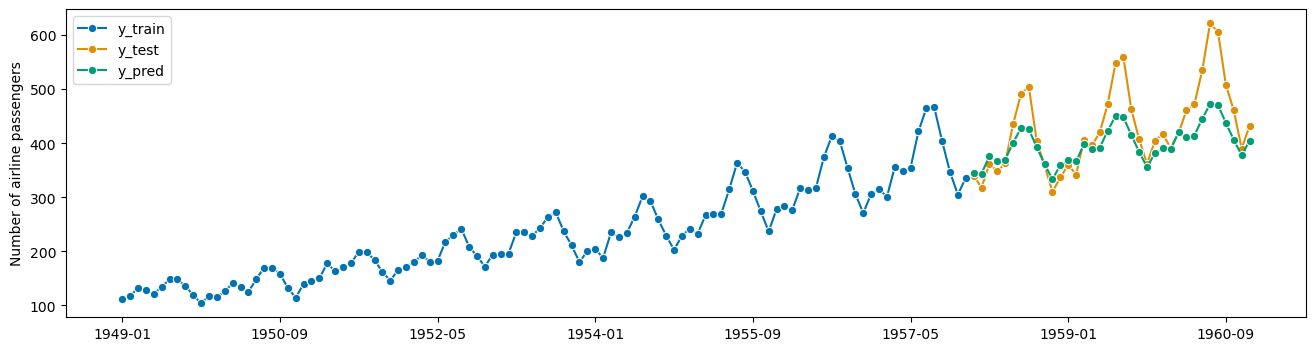

In [234]:
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)

forecaster.fit(y_train)
y_pred = forecaster.predict(y_test.index)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

As clearly visible, using complex models on relatively simple data is not always a good idea. Here the result is much worse than the relatively simpler ETS model.

### Prophet

Prophet is a very popular package initially developed by facebook and later open-sourced. As per the docs it fits "an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data." It's popularity largerly comes from its relative simplicity of use. 

12:17:29 - cmdstanpy - INFO - Chain [1] start processing
12:17:29 - cmdstanpy - INFO - Chain [1] done processing


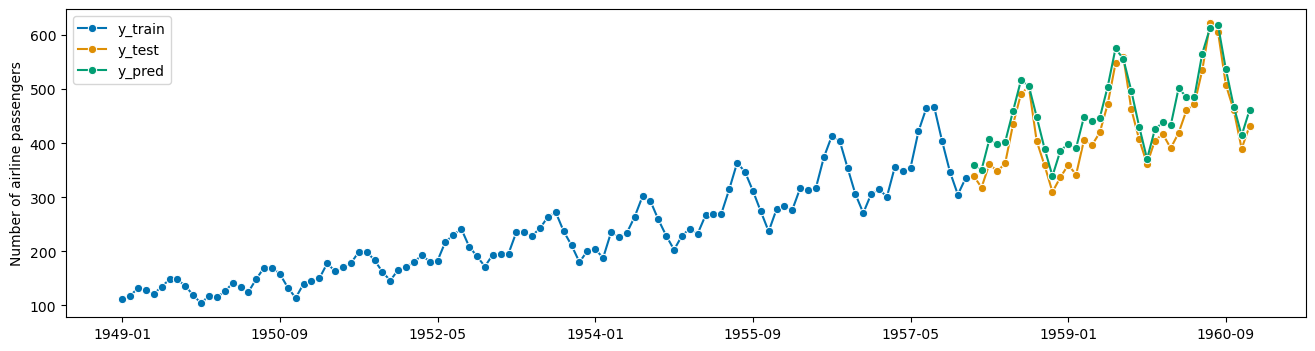

In [237]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet()
forecaster = Prophet(
seasonality_mode="multiplicative",
)
forecaster.fit(y_train)
y_pred = forecaster.predict(y_test.index)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);

## Exercise

1. Import the data ```DailyDelhiClimateTrain.csv``` from the datasets folder
2. Using ```pd.to_datetime``` turn the date column into an actual date object and set that column as index of the dataframe
3. Keep only the ```meantemp``` column
4. Create a Prophet model of these data
5. Do a prediction for a thousand datapoints
6. Plot the prediction
7. Load the ```DailyDelhiClimateTest.cvs``` file and format it in the same way.
8. Do a prediction for the dates of this test dataset
9. Plot the data and the prediction together